In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import xml.etree.ElementTree as ET
import pandas as pd
import os
import glob2 as glob

In [3]:
PATH = Path('/data2/imageCLEF2013/')

In [9]:
trn_df = pd.DataFrame()
image_list = []

for f in (PATH/'train').glob('*.xml'):
    tree = ET.parse(f)
    fn = os.path.join('train',tree.find('FileName').text)
    plantid = tree.find('IndividualPlantId').text
    bg_type = tree.find('Type').text
    content = tree.find('Content').text
    class_id = tree.find('ClassId').text
    image_list.append([fn, plantid, bg_type, content, class_id])

In [19]:
trn_df = pd.DataFrame(image_list, columns=['filename', 'plantid', 'background_type', 'content', 'classid'])

In [20]:
trn_df.to_csv(PATH/'train.csv', index=False)

In [4]:
trn_df = pd.read_csv(PATH/'train.csv')

In [5]:
trn_df.head()

filename  plantid    background_type content                 classid
0  train/0.jpg      470  NaturalBackground    Leaf        Corylus avellana
1  train/1.jpg      246  SheetAsBackground    Leaf        Ruscus aculeatus
2  train/2.jpg       94  SheetAsBackground    Leaf  Phillyrea angustifolia
3  train/3.jpg      742  SheetAsBackground    Leaf       Rhamnus alaternus
4  train/4.jpg      630  NaturalBackground    Leaf            Hedera helix

In [9]:
trn_df['classid'].value_counts()

Quercus ilex                   437
Ulmus minor                    398
Viburnum tinus                 383
Phillyrea angustifolia         358
Hedera helix                   348
Cercis siliquastrum            347
Olea europaea                  322
Celtis australis               319
Buxus sempervirens             305
Populus nigra                  305
Pittosporum tobira             304
Robinia pseudoacacia           299
Crataegus monogyna             297
Platanus x hispanica           285
Arbutus unedo                  284
Ruscus aculeatus               267
Betula pendula                 258
Acer negundo                   250
Nerium oleander                239
Cotinus coggygria              238
Euphorbia characias            236
Populus alba                   228
Aesculus hippocastanum         227
Corylus avellana               225
Diospyros kaki                 223
Acer campestre                 217
Acer monspessulanum            212
Ginkgo biloba                  201
Pistacia lentiscus  

In [5]:
data = ImageDataBunch.from_df(PATH, trn_df, fn_col=0, 
                              label_col=4, ds_tfms=get_transforms(flip_vert=True), size=512, bs=24)

### Plot image sizes in order to test progressive resizing limits

In [6]:
train_fnames = data.train_ds.ds.x

In [7]:
type(train_fnames)

numpy.ndarray

In [10]:
import PIL

In [11]:
size_d = {k: PIL.Image.open(k).size for k in train_fnames}

In [12]:
row_sz, col_sz = list(zip(*size_d.values()))

In [13]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

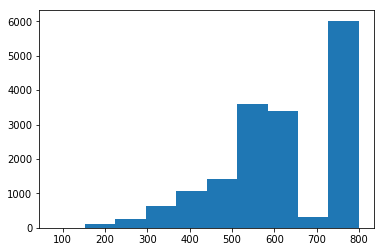

In [14]:
plt.hist(row_sz);

In [11]:
len(data.classes)

250

In [8]:
data.normalize(imagenet_stats)

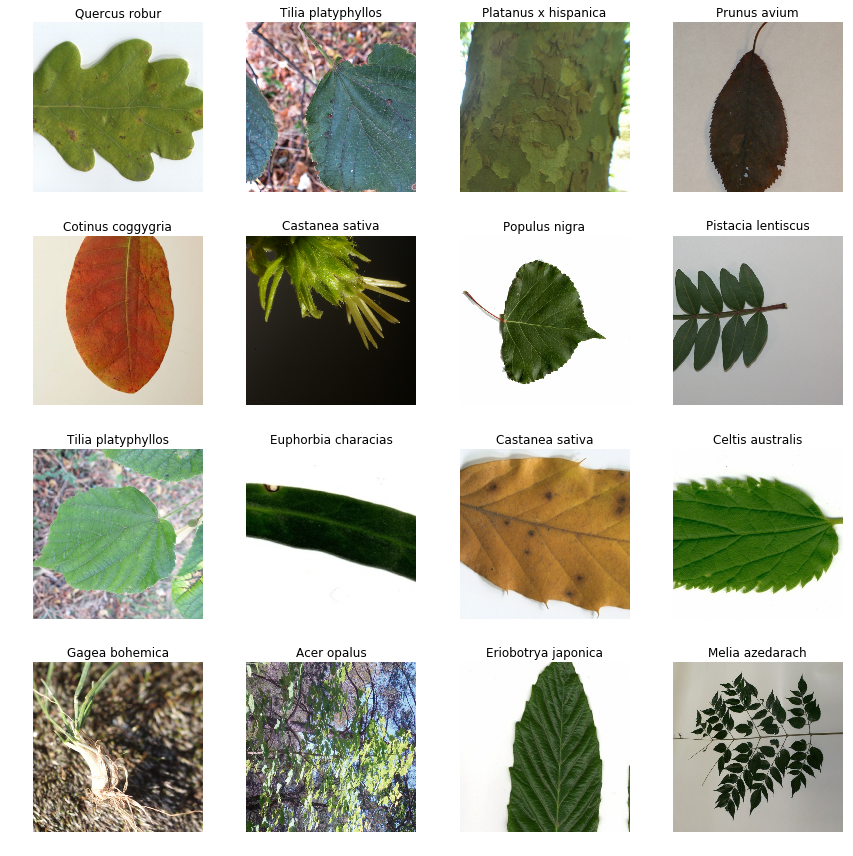

In [10]:
data.show_batch(rows=4, figsize=(12, 12))

In [11]:
def error_rate(preds, targs): return 1 - accuracy(preds, targs)

learn = ConvLearner(data, models.tvm.resnet50, metrics=error_rate, ps=0.6)

In [15]:
learn.fit_one_cycle(4)

Total time: 20:21
epoch  train loss  valid loss  <lambda>
0      2.756965    2.065560    0.442453  (05:15)
1      1.908005    1.458315    0.335377  (05:02)
2      1.415768    1.128394    0.261085  (05:01)
3      1.107359    1.060126    0.244340  (05:01)



In [16]:
learn.lr_find()

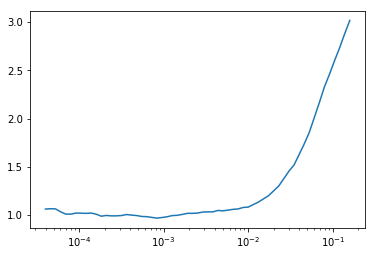

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-3))

Total time: 20:08
epoch  train loss  valid loss  <lambda>
0      1.060849    1.024458    0.237736  (05:02)
1      1.048097    0.967119    0.222170  (05:02)
2      0.906364    0.920350    0.211557  (05:01)
3      0.820760    0.908619    0.210377  (05:01)



In [19]:
interp = ClassificationInterpretation.from_learner(learn)

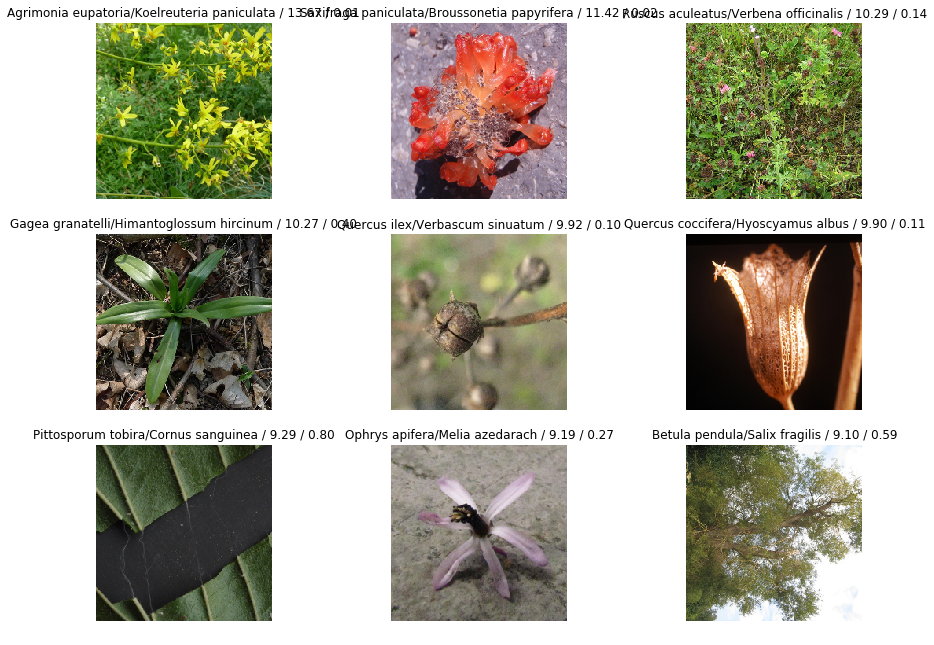

In [20]:
interp.plot_top_losses(9, figsize=(15, 11))

In [21]:
interp.most_confused(min_val=2)

[('Quercus robur', 'Quercus pubescens', 7),
 ('Acer platanoides', 'Quercus robur', 4),
 ('Prunus avium', 'Prunus padus', 3),
 ('Viburnum tinus', 'Laurus nobilis', 3),
 ('Buxus sempervirens', 'Pittosporum tobira', 3),
 ('Fraxinus angustifolia', 'Fraxinus excelsior', 3),
 ('Pittosporum tobira', 'Laurus nobilis', 3),
 ('Robinia pseudoacacia', 'Acer negundo', 3),
 ('Magnolia grandiflora', 'Pittosporum tobira', 3),
 ('Broussonetia papyrifera', 'Alnus glutinosa', 3),
 ('Acer pseudoplatanus', 'Platanus x hispanica', 3),
 ('Quercus pubescens', 'Quercus robur', 3),
 ('Platanus x hispanica', 'Aesculus hippocastanum', 3),
 ('Sophora japonica', 'Robinia pseudoacacia', 3),
 ('Tilia dasystyla', 'Prunus serrulata', 3),
 ('Betula utilis', 'Betula pendula', 3),
 ('Quercus rubra', 'Quercus pubescens', 3)]

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-3))

Total time: 32:58
epoch  train loss  valid loss  <lambda>
0      0.827237    0.905729    0.210613  (06:41)
1      0.910749    0.876395    0.208491  (06:34)
2      0.724283    0.771113    0.181132  (06:34)
3      0.563559    0.732095    0.172877  (06:34)
4      0.500654    0.717716    0.169340  (06:34)



In [26]:
learn.lr_find(start_lr=1e-8)

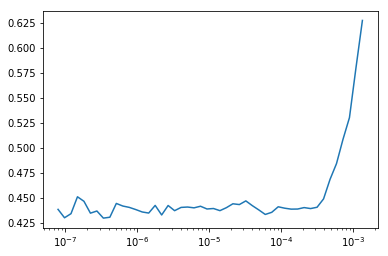

In [27]:
learn.recorder.plot()

In [28]:
learn.save('plant-types-v1')

In [27]:
learn.load('plant-types-v1')

In [28]:
learn.lr_find(start_lr=1e-8)

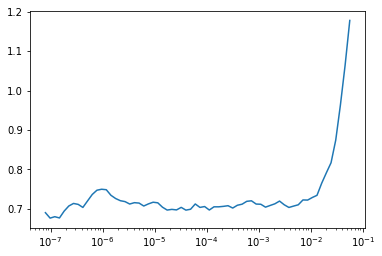

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))

Total time: 29:57
epoch  train loss  valid loss  error_rate
0      0.719813    0.262790    0.061224    (06:08)
1      0.736251    0.297222    0.071311    (05:57)
2      0.672177    0.301158    0.071780    (05:56)
3      0.570621    0.290553    0.070138    (05:56)
4      0.510798    0.292168    0.070608    (05:57)



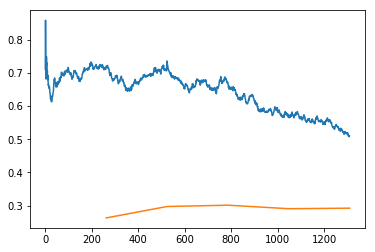

In [31]:
learn.recorder.plot_losses()

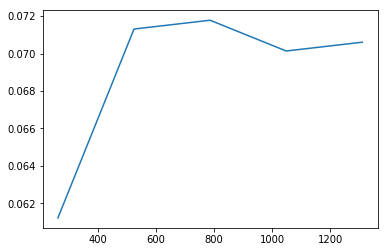

In [32]:
learn.recorder.plot_metrics()

In [35]:
learn.lr_find(start_lr=1e-6)

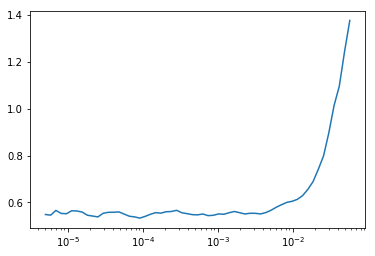

In [36]:
learn.recorder.plot()

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

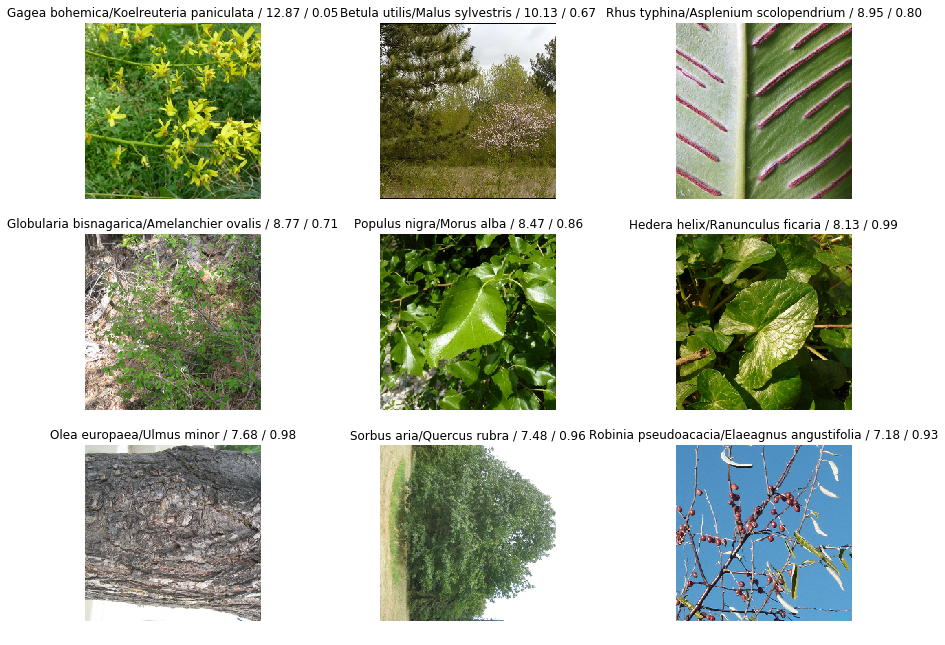

In [38]:
interp.plot_top_losses(9, figsize=(15, 11))

In [41]:
interp.most_confused()

[('Quercus coccifera', 'Quercus ilex', 4),
 ('Fraxinus excelsior', 'Olea europaea', 3),
 ('Quercus robur', 'Quercus pubescens', 3),
 ('Acer negundo', 'Fraxinus excelsior', 3),
 ('Prunus avium', 'Prunus padus', 2),
 ('Anacamptis morio', 'Orchis mascula', 2),
 ('Buxus sempervirens', 'Olea europaea', 2),
 ('Robinia pseudoacacia', 'Fraxinus excelsior', 2),
 ('Sambucus nigra', 'Viburnum tinus', 2),
 ('Laurus nobilis', 'Olea europaea', 2),
 ('Acer pseudoplatanus', 'Aesculus hippocastanum', 2),
 ('Melia azedarach', 'Robinia pseudoacacia', 2),
 ('Sophora japonica', 'Robinia pseudoacacia', 2),
 ('Malva sylvestris', 'Epilobium angustifolium', 2),
 ('Acer negundo', 'Platanus x hispanica', 2),
 ('Rhamnus cathartica', 'Prunus mahaleb', 2),
 ('Mespilus germanica', 'Prunus mahaleb', 2),
 ('Gagea granatelli', 'Gagea bohemica', 2),
 ('Quercus cerris', 'Quercus pubescens', 2),
 ('Salix caprea', 'Castanea sativa', 2),
 ('Blechnum spicant', 'Albizia julibrissin', 2)]

In [42]:
learn.fit_one_cycle(10, max_lr=slice(1e-5, 1e-3))

Total time: 59:33
epoch  train loss  valid loss  error_rate
0      0.546937    0.285792    0.070373    (05:58)
1      0.548846    0.295063    0.072484    (05:57)
2      0.596660    0.309046    0.076941    (05:57)
3      0.585393    0.328437    0.083040    (05:57)
4      0.551422    0.322842    0.080460    (05:56)
5      0.512396    0.318808    0.079991    (05:58)
6      0.482287    0.314333    0.081633    (05:57)
7      0.450959    0.308824    0.080225    (05:57)
8      0.424016    0.307364    0.079521    (05:57)
9      0.415924    0.307075    0.080694    (05:56)



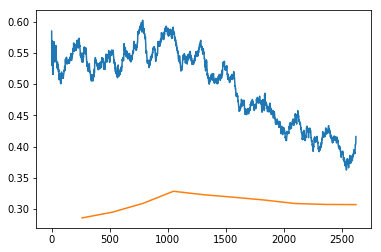

In [43]:
learn.recorder.plot_losses()

In [46]:
learn.lr_find(start_lr=1e-8)

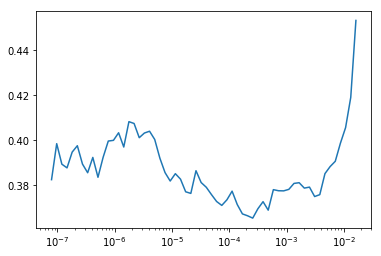

In [47]:
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(10, max_lr=slice(8e-6, 3e-4))

Total time: 59:28
epoch  train loss  valid loss  error_rate
0      0.409476    0.304475    0.078818    (05:56)
1      0.400543    0.301189    0.074830    (05:57)
2      0.428901    0.300937    0.075534    (05:56)
3      0.397546    0.303571    0.077176    (05:56)
4      0.406544    0.302290    0.074830    (05:56)
5      0.396954    0.302344    0.076472    (05:57)
6      0.368312    0.300987    0.073422    (05:56)
7      0.373755    0.296777    0.073422    (05:57)
8      0.351501    0.297042    0.073188    (05:56)
9      0.341764    0.295438    0.072719    (05:56)



In [69]:
learn.save('plant-types-v2')

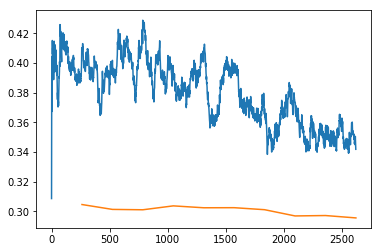

In [70]:
learn.recorder.plot_losses()

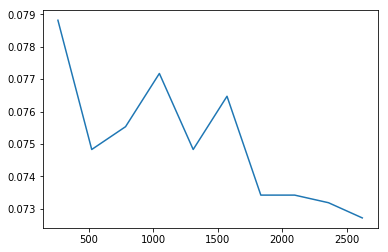

In [74]:
learn.recorder.plot_metrics()

In [71]:
interp = ClassificationInterpretation.from_learner(learn)

In [72]:
interp.most_confused()

[('Corylus avellana', 'Tilia platyphyllos', 2),
 ('Prunus avium', 'Prunus mahaleb', 2),
 ('Celtis australis', 'Prunus avium', 2),
 ('Quercus coccifera', 'Quercus ilex', 2),
 ('Anacamptis morio', 'Orchis mascula', 2),
 ('Liquidambar styraciflua', 'Acer negundo', 2),
 ('Laurus nobilis', 'Olea europaea', 2),
 ('Quercus robur', 'Quercus pubescens', 2),
 ('Melia azedarach', 'Ailanthus altissima', 2),
 ('Melia azedarach', 'Robinia pseudoacacia', 2),
 ('Sophora japonica', 'Robinia pseudoacacia', 2),
 ('Fraxinus ornus', 'Acer negundo', 2),
 ('Malva sylvestris', 'Epilobium angustifolium', 2),
 ('Acer negundo', 'Fraxinus excelsior', 2),
 ('Acer negundo', 'Platanus x hispanica', 2),
 ('Rhamnus cathartica', 'Prunus mahaleb', 2),
 ('Mespilus germanica', 'Prunus mahaleb', 2),
 ('Gagea granatelli', 'Gagea bohemica', 2),
 ('Dactylorhiza fuchsii', 'Dactylorhiza maculata', 2),
 ('Salix caprea', 'Castanea sativa', 2),
 ('Quercus rubra', 'Sophora japonica', 2),
 ('Blechnum spicant', 'Albizia julibrissin',

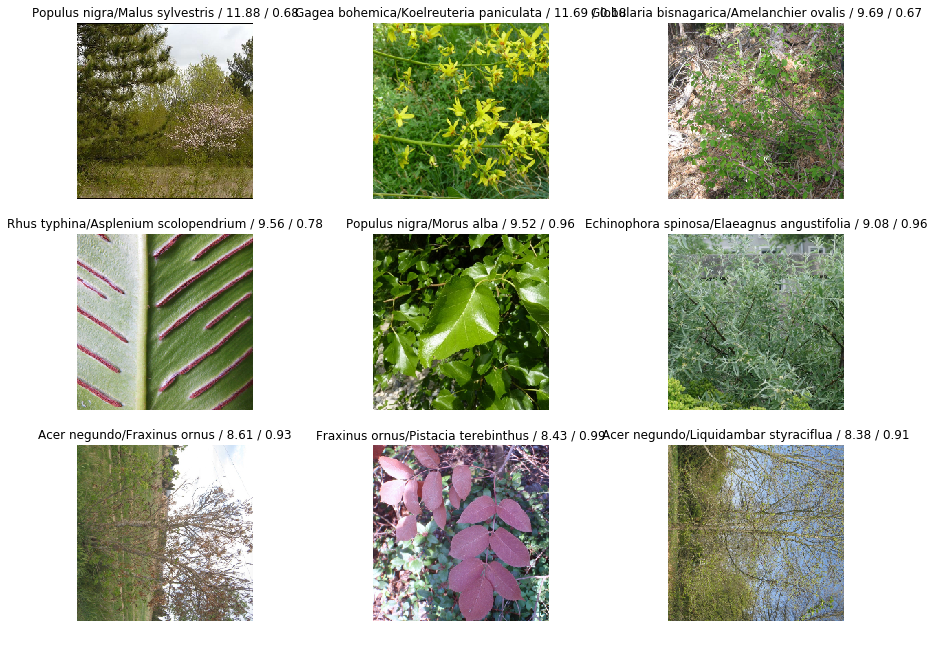

In [73]:
interp.plot_top_losses(9, figsize=(15, 11))

### Resizing to 512
This required that I drop the batch size to 24, as the GPU kept running out of memory. As you can see, the results from the first attempt to train were much worse results than in the previous training run, which suggests that using the previous `max_lr` isn't sufficient. We have to use the learning-rate finder to select new settings. I restarted the kernel, loaded the previous saved model, and ran the lr_finder once before setting new params.

In [12]:
learn.load('plant-types-v2')

In [13]:
learn.fit_one_cycle(1, max_lr=slice(8e-6, 3e-4))

Total time: 23:51
epoch  train loss  valid loss  error_rate
0      1.087774    0.292891    0.075887    (23:51)



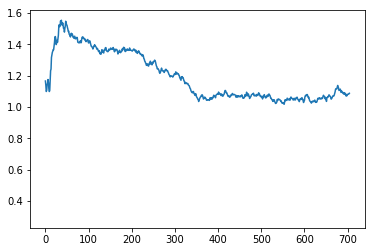

In [14]:
learn.recorder.plot_losses()

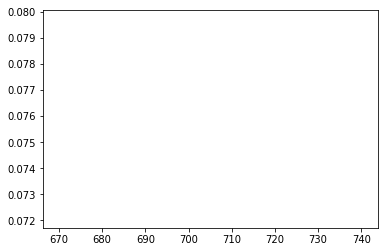

In [15]:
learn.recorder.plot_metrics()

In [16]:
learn.lr_find()

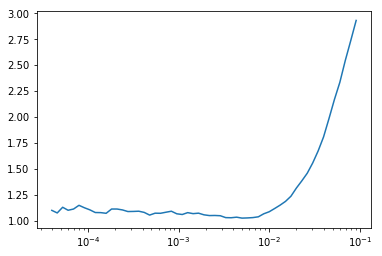

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(10, max_lr=slice(1e-5, 1e-3))

Total time: 3:52:50
epoch  train loss  valid loss  error_rate
0      0.930282    0.271274    0.075398    (23:15)
1      0.933587    0.288781    0.075887    (23:15)
2      0.915133    0.337147    0.091310    (23:15)
3      0.888642    0.380831    0.100367    (23:14)
4      0.815352    0.381876    0.101836    (23:17)
5      0.723552    0.377175    0.098898    (23:20)
6      0.644393    0.367633    0.099388    (23:20)
7      0.635122    0.346127    0.092289    (23:19)
8      0.573779    0.342522    0.091799    (23:17)
9      0.612760    0.341726    0.091310    (23:14)



In [21]:
learn.lr_find(start_lr=1e-8)

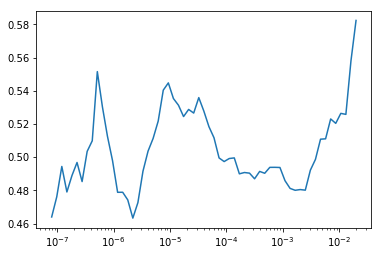

In [22]:
learn.recorder.plot()

In [23]:
learn.save('plant-types-v3')

In [25]:
learn.load('plant-types-v3')

In [24]:
learn.fit_one_cycle(10, max_lr=slice(8e-5, 2e-3))

Total time: 3:53:07
epoch  train loss  valid loss  error_rate
0      0.645732    0.360692    0.095716    (23:13)
1      0.910284    0.417387    0.105753    (23:17)
2      1.022460    0.538552    0.132436    (23:19)
3      1.025378    0.553943    0.138800    (23:19)
4      0.930188    0.537087    0.135373    (23:19)
5      0.848617    0.486427    0.123133    (23:19)
6      0.688010    0.452594    0.115545    (23:19)
7      0.573265    0.436406    0.109425    (23:19)
8      0.542856    0.422270    0.105998    (23:19)
9      0.497268    0.418780    0.103550    (23:19)



In [26]:
class SaveFeatures:
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output):
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self):
        self.hook.remove()

In [30]:
#model to eval mode (don't use dropout anymore)
learn.model.eval()

# Get validation features

# specify layer to store (last real layer before the predictions (last two are a dropout layer and the actual predictions))
sf = SaveFeatures(learn.model[-1][-3])

# predict TODO:Refactor and understand last 3 lines
n_valid = len(data.valid_ds.ds.y)
for i in range(n_valid):
    # get image
    img,label = data.valid_dl.dl.dataset[i]
    # transform
    img = apply_tfms(learn.data.valid_ds.tfms, img, **learn.data.valid_ds.kwargs)
    # lines copied from fastai.vision.learner._predict
    ds = TensorDataset(img.data[None], torch.zeros(1))
    dl = DeviceDataLoader.create(ds, bs=1, shuffle=False, device=learn.data.device, tfms=learn.data.valid_dl.tfms,
                                     num_workers=0)
    pred = learn.model(dl.one_batch()[0])
    
    if i % 1000 == 0:
        print(f'{i/n_valid*100:.2f}% ready')

# get features
X_valid = sf.features
# store labels
y_valid = data.valid_ds.ds.y


0.00% ready
24.48% ready
48.96% ready
73.44% ready
97.92% ready


In [33]:
# Get training set features

# specify layer to store (last real layer before the predictions (last two are a dropout layer and the actual predictions))
sf = SaveFeatures(learn.model[-1][-3])

# predict TODO:Refactor and understand last 3 lines
n_train = len(data.train_ds.ds.y)
for i in range(n_train):
    # get image
    img,label = data.train_dl.dl.dataset[i]
    # transform
    img = apply_tfms(learn.data.train_ds.tfms, img, **learn.data.train_ds.kwargs)
    # lines copied from fastai.vision.learner._predict
    ds = TensorDataset(img.data[None], torch.zeros(1))
    dl = DeviceDataLoader.create(ds, bs=1, shuffle=False, device=learn.data.device, 
                                 tfms=learn.data.train_dl.tfms, num_workers=0)
    pred = learn.model(dl.one_batch()[0])
    
    if i % 1000 == 0:
        print(f'{i/n_train*100:.2f}% ready')

# get features
X_train = sf.features
# store labels
y_train = data.train_ds.ds.y


0.00% ready
5.92% ready
11.83% ready
17.75% ready
23.67% ready
29.59% ready
35.50% ready
41.42% ready
47.34% ready
53.25% ready
59.17% ready
65.09% ready
71.01% ready
76.92% ready
82.84% ready
88.76% ready
94.67% ready


#### Use PCA to make linearly-independent features based on how much internal variation they capture

In [37]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [35]:
n_components = X_train.shape[1]
pca = PCA(n_components)
# fit on training data, to avoid overfitting if the PCA features are used for a classifier
PCA_X_train = pca.fit_transform(X_train)
PCA_X_valid = pca.transform(X_valid)

In [ ]:
# train a logistic regression model with L1 Regularization, to learn which features are most important for classifying specific plant types
Cs = np.logspace(-4, 4, 10)
results = pd.DataFrame(index=Cs, columns=['train_score', 'valid_score'])
for C in Cs:
    clf = LogisticRegression(penalty='l1', C=C).fit(PCA_X_train, y_train)
    results.loc[C, 'train_score'] = clf.score(PCA_X_train, y_train)
    results.loc[C, 'valid_score'] = clf.score(PCA_X_valid, y_valid)

In [ ]:
results

In [ ]:
# train a model with optimal C
clf = LogisticRegression(penalty='l1', C=).fit(PCA_X_train, y_train)
print(clf.score(PCA_X_valid, y_valid))

In [ ]:
coefs = clf.coef_

In [ ]:
feature_importances = np.abs(coefs).sum(axis=0)
feature_importances

## Explore features

In [ ]:
sorts = {}
for i in range(n_components):
    sorts[i] = np.argsort(PCA_X_valid[:, i])[::-1]

In [ ]:
def show_valid(id_list, n_cols=5):
    fig, axs = plt.subplots(int(np.ceil(len(id_list)/n_cols)), n_cols, figsize=(20, 10))
    for i, ax in enumerate(axs.flatten()):
        img, label = data.valid_dl.dl.dataset[id_list[i]]
        show_image(img, ax=ax)
    return plt.tight_layout()

In [ ]:
len(sorts.keys())

In [ ]:
f = 0
print(f'Plants with least/most of feature {f}')
show_valid(sorts[f][-6:-1])
show_valid(sorts[f][0:5])

In [ ]:
f = 1
print(f'Plants with least/most of feature {f}')
show_valid(sorts[f][-6:-1])
show_valid(sorts[f][0:5])